# PONCE_SALAFRANCA AGE PREDICTION


## D. Age Classification
Automatic gender classification has been used in many applications. The goal of this project is to classify
the gender of faces in an image. One can design a convolutional neural network or Transformer to achieve
this goal. Some tasks to consider:
1. Modify some previously published architectures e.g., increase the network depth, reducing their
parameters, etc. Explore more advanced techniques such as deformable convolution, dilated
convolution (dilation>1) or visual prompt tuning for Transformers.
2. Consider age and gender recognition simultaneously to take advantage of the gender-specific age
characteristics and age-specific gender characteristics inherent to images
3. Consider pre-training using the CelebA dataset
http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html


References
1. G. Levi and T. Hassner, “Age and gender classification using convolutional neural networks.” in
IEEE Conf. on Computer Vision and Pattern Recognition (CVPR) workshops, 2015
2. Z. Liu and P. Luo and X. Wang, and X. Tang, “Deep learning face attributes in the wild,” in
International Conference on Computer Vision (ICCV), 2015

### 1.0 We do import all the important packages for the work.

We are going to use several packages for this assignement

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import KFold

import cv2
import random
from PIL import Image
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalMaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import optimizers
from tensorflow import keras

import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import EfficientNetB5

import tensorflow as tf
print(tf.__version__)

2.16.1


### 1.1 We know import all the data usefull for the work

In [2]:
ADIENCE_PATH = './Adience'
all_folds={}
for i in range(5):
    all_folds[i]=pd.read_csv(os.path.join(ADIENCE_PATH, f'fold_{i}_data.txt'),sep = "\t" )
total_data = pd.concat([all_folds[i] for i in range(5)],ignore_index=True)

### 1.2 Preprocessing of the data 


In [3]:
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


We can observe that we have 19370 entries of data. However, only 18591 have a value for gender and 18622 for age. We need to look into that in the future, as the may not be useful for training/testing/validation. As we are going to work with these to variables (age and gender) let's check how the distribution is across the data. 

Also we can check that the possible values for gender are 'f' (female), 'm' (male) and 'u' (undefined). For age, we can observe that we have a mix of individual values and intervals. In this part we will make the following changes:
 - Drop all the rows that contain NaN values (in any column) of the data set as they are not interesting and won't lead to ueful information.
 - Group age by intervals which make sense. On the original data set we have different entries for example for (0,2) and '2' which should be in the same interval.
 - In the gender variable we will need to drop 'u', as it is not useful beacuse we are trying to classify between male and female.
 - Joining the two columns user_id and original_image, as it is just the way in which the pictures are stored in the data set. We can combine them to create a path.

In [4]:
df = total_data[['age', 'gender']].copy()
img_path = []

for row in total_data.iterrows():
    path = f"{ADIENCE_PATH}/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)
df['img_path'] = img_path

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       19370 non-null  object
 1   gender    18591 non-null  object
 2   x         19370 non-null  int64 
 3   y         19370 non-null  int64 
 4   dx        19370 non-null  int64 
 5   dy        19370 non-null  int64 
 6   img_path  19370 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.0+ MB


Firstly, we will combine user_id and original_image into a new variable named image_path which will contain the path in the folder to the picture described by the data:

#### We do the mapping of age and gender

Third, we will group age old values into intervals. Unfortunatley its impossible to make the intervals have the same length as we are constrained by some of them were already given and are of varying lenghts. We tried keeping them as short as possible while still being an interval:

In [5]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '3-6'), 
               ('(4, 6)', '3-6'), ('(8, 12)', '8-23'), ('13', '8-23'),
               ('22', '8-23'), ('(8, 23)','8-23'), ('23', '8-23'),
               ('(15, 20)', '8-23'), ('(25, 32)', '25-32'),
               ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '38-48'),
               ('29', '25-32'), ('(38, 42)', '38-48'), ('35', '38-48'),
               ('36', '38-48'), ('42', '38-48'), ('45', '38-48'), 
               ('(38, 43)', '38-48'), ('(38, 42)', '38-48'),
               ('(38, 48)', '38-48'), ('46', '38-48'), ('(48, 53)', '48-59'),
               ('55', '48-59'), ('56', '48-59'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

df = df.drop(labels=drop_labels, axis=0) #droped None values
df.age.value_counts(dropna=False)

C:\Users\jaime\AppData\Local\Temp\ipykernel_7444\924423691.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.age.loc[idx] = age_mapping_dict[each]


25-32    5095
8-23     4180
38-48    2889
0-2      2491
3-6      2158
48-59     908
60+       901
Name: age, dtype: int64

Second, we drop the NaNs values as we can't work with them. This function will search for NaN's in any column and delete the complete row where they were stored:

Fourth, we will eliminate the 'u' values of the gender variable as they are not associated with either males or females and the objective of this work is to distinguish between them:

In [6]:
df = df.dropna()
df = df[df.gender != 'u'].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17452 entries, 0 to 19345
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       17452 non-null  object
 1   gender    17452 non-null  object
 2   x         17452 non-null  int64 
 3   y         17452 non-null  int64 
 4   dx        17452 non-null  int64 
 5   dy        17452 non-null  int64 
 6   img_path  17452 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


Lastly, we will create some mapping of both age and gender. We will map gender as 0 (female) and 1 (male) and age with values from 0 to 8 for the intervals created:

In [7]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

age_to_label_map = {
    '0-2'  :0,
    '3-6'  :1,
    '8-23' :2,
    '25-32':3,
    '38-48':4,
    '48-59':5,
    '60+'  :6
}

# label_to_age_map = {value: key for key, value in age_to_label_map.items()}
# label_to_gender_map = {value: key for key, value in gender_to_label_map.items()}

df['age'] = df['age'].apply(lambda age: age_to_label_map[age])
df['gender'] = df['gender'].apply(lambda g: gender_to_label_map[g])

df.head()

,age,gender,x,y,dx,dy,img_path
0,3,0,0,414,1086,1383,./Adience/faces/30601258@N03/coarse_tilt_align...
1,3,1,301,105,640,641,./Adience/faces/30601258@N03/coarse_tilt_align...
2,3,0,2395,876,771,771,./Adience/faces/30601258@N03/coarse_tilt_align...
3,3,1,752,1255,484,485,./Adience/faces/30601258@N03/coarse_tilt_align...
4,3,1,175,80,769,768,./Adience/faces/30601258@N03/coarse_tilt_align...


Text(0.5, 0, 'Number of people')

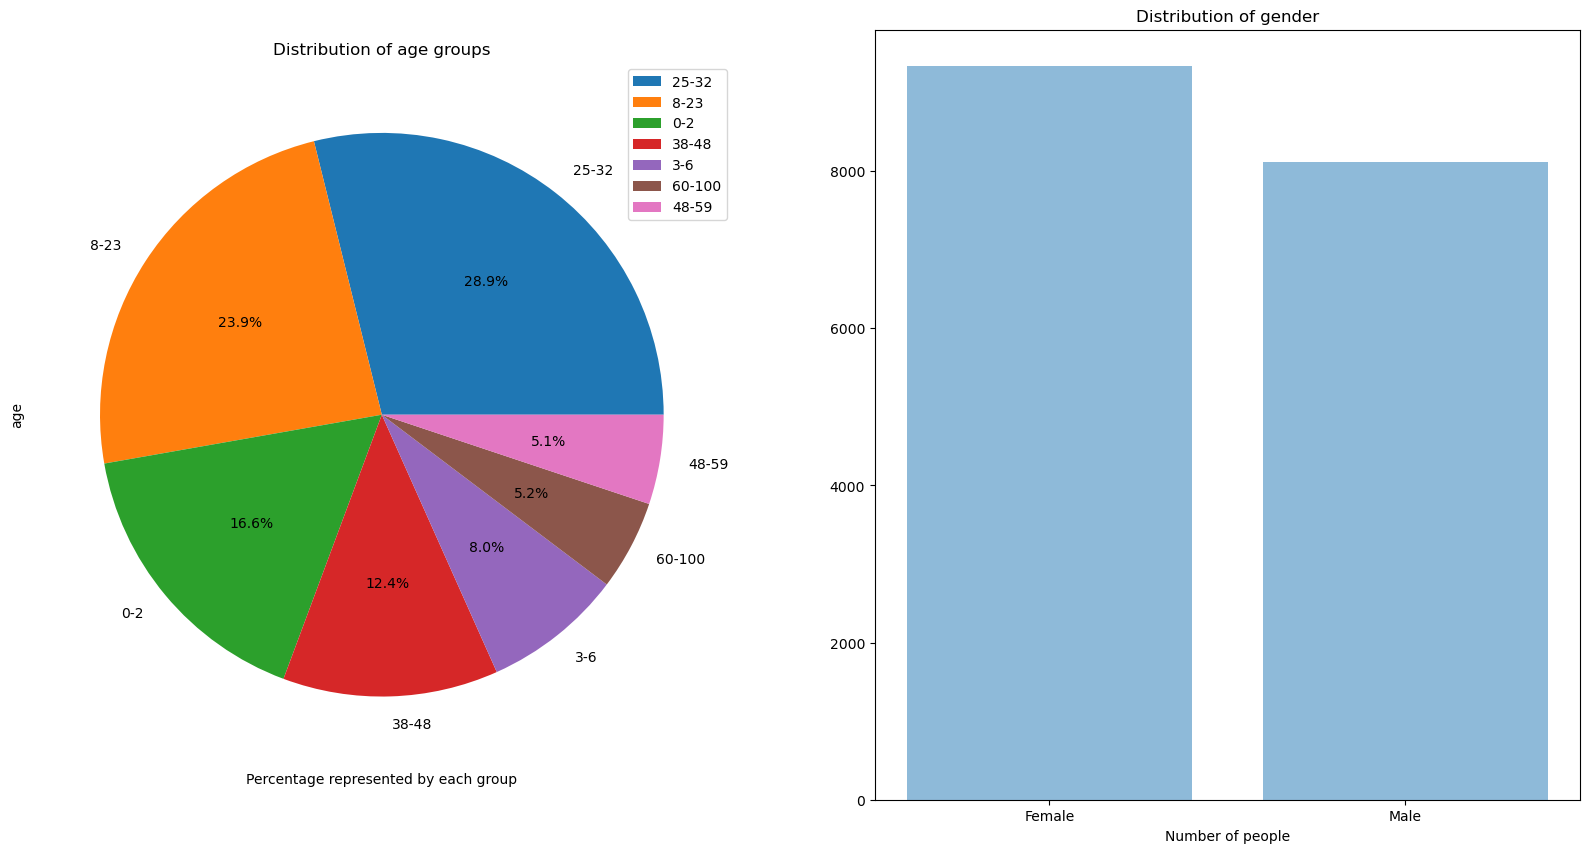

In [9]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.title('Distribution of age groups')
plt.xlabel('Percentage represented by each group')
df.age.value_counts().plot.pie(autopct = "%1.1f%%", labels = age_to_label_map)
plt.legend()
plt.subplot(1,2,2)
gender = ['Female','Male']
plt.bar(gender, df.gender.value_counts(), align = 'center', alpha = 0.5)
plt.title('Distribution of gender')
plt.xlabel('Number of people')

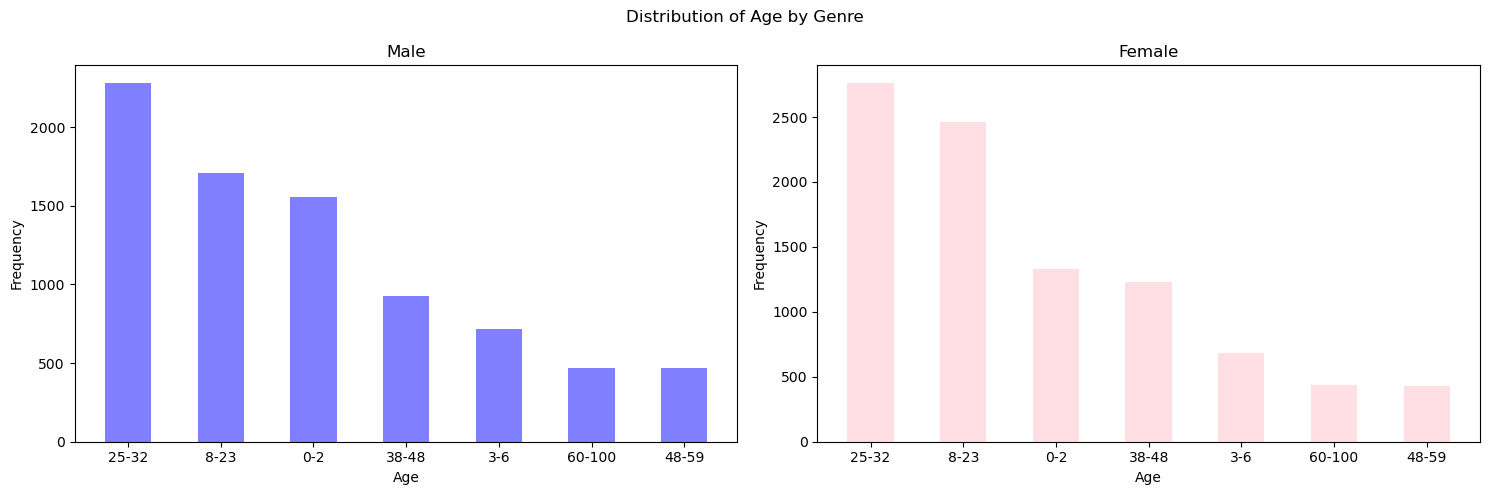

In [10]:
male_data = df[df.gender == 1].copy()
female_data = df[df.gender == 0].copy()
# Create subplots for each genre
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot histograms for each genre
axs[0].bar(age_to_label_map, male_data.age.value_counts(), alpha=0.5, color='blue', width=0.5)
axs[0].set_title('Male')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frequency')

axs[1].bar(age_to_label_map, female_data.age.value_counts(), alpha=0.5, color='pink', width=0.5)
axs[1].set_title('Female')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Frequency')


plt.suptitle('Distribution of Age by Genre')
plt.tight_layout()
plt.show()

As we can see the gender is pretty equally distributed which is good for the training of the future models. However, the age has a few groups which are very small. In the future, we will have to see if errors are in this groups whoch could be due to small training group for this age groups. in that case we will reorganise.

### 1.3 We create the Datasets for training, testing and validation.

The X part will, for the moment, contain de image path. Y will contain the gender of the person in the image. we will divide the dataset into a 75:25 training to testing split:

In [35]:
X = df[['img_path']]
y = df[['age']]

from sklearn.model_selection import train_test_split

Xtrain, X_temp, ytrain, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
Xvalidation, Xtest, yvalidation, ytest = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print('Train data shape {}'.format(Xtrain.shape))
print('Validation data shape{}'.format(Xvalidation.shape))
print('Test data shape {}'.format(Xtest.shape))

Train data shape (12216, 1)
Validation data shape(2618, 1)
Test data shape (2618, 1)


In [12]:
# Xtrain = Xtrain[:2000]
# Xtest = Xtest[:2000]
# Xvalidation = Xvalidation[:2000]
# ytrain = ytrain[:2000]
# ytest = ytest[:2000]
# yvalidation = yvalidation[:2000]

### 1.4 Resizing of images

We will create different data sets with different image reduction, so in the futrue we can compare model performance:

In [13]:
train_images = []
test_images = []
validation_images = []

for row in Xtrain.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((200, 200))   # Resize the image
    data = np.asarray(image)
    # TODO: np.float
    train_images.append(data)

for row in Xtest.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((200, 200))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)
    
for row in Xvalidation.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((200, 200))  # Resize the image
    data = np.asarray(image)
    validation_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)
validation_images = np.asarray(validation_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))
print('Validation images shape {}'.format(validation_images.shape))

Train images shape (12216, 200, 200, 3)
Test images shape (2618, 200, 200, 3)
Validation images shape (2618, 200, 200, 3)


### 1.4 Creation of a simple Model



We use similar parameters for this models that the ones that we will use for the paper model.


In [14]:
batch_size = 50
epochs = 20
target_size = (200, 200) # (64, 64)
input_shape = (200, 200, 3) #(64, 64, 3)

# random seed
SEED = 10
np.random.seed(SEED)
tf.random.set_seed(SEED)

adam = 0.001
fre = -20
FC = 2048
E = 1
patience = 5
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch = 256
validation_steps = 256

drop_out_rate = 0.5

We create the EfficientNet

In [15]:
model = EfficientNetB5(weights='imagenet',include_top=False, input_shape=input_shape)


Model: "efficientnetb5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 200, 200, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 200, 200, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 200, 200, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 200, 200, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 201, 201, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 100, 100, 48)      │           1,296 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 100, 100, 48)      │             192 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 100, 100, 48)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 100, 100, 48)      │             432 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 100, 100, 48)      │             192 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 100, 100, 48)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 48)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 48)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 12)          │             588 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 48)          │             624 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 28,513,527 (108.77 MB)

 Trainable params: 28,340,784 (108.11 MB)

 Non-trainable params: 172,743 (674.78 KB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.168329 to fit



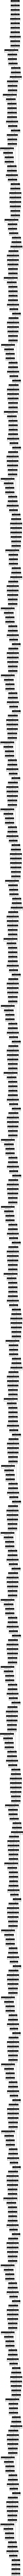

In [16]:
from tensorflow.keras.utils import plot_model

model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)


In [40]:
model.trainable = False # Previous partcrated with image net doesn't train with time 
output= GlobalAveragePooling2D()( model.output)
output = Dense(1024, activation="relu")(outputoutput)
output = Dropout(0.5)(output)
output = Dense(512, activation="relu")(output)
# 2 -> 1
predictions = Dense(7, activation="softmax")(output)

In [18]:
model2 = Model(inputs=model.input, outputs=predictions)


In [41]:
model2.compile(optimizer=Adam(adam),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
def get_call_backs():
    lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = patience,verbose = verbose,factor = factor,min_lr = min_lr)
    mcp = ModelCheckpoint('age_model.keras')
    es = EarlyStopping(verbose=verbose, patience=patience)
    
    return [lrd, mcp, es]

In [43]:
from tensorflow.keras.utils import to_categorical
ytrain_encoded = to_categorical(ytrain, num_classes=7)
yvalidation_encoded = to_categorical(yvalidation, num_classes=7)
ytest_encoded = to_categorical(ytest, num_classes=7)

### 1.5 Training of the model

In [44]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [45]:
history = model2.fit(
    train_images, ytrain, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(test_images, ytest), 
    callbacks=get_call_backs())

Epoch 1/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 1213s 5s/step - accuracy: 0.5293 - loss: 1.1577 - val_accuracy: 0.5466 - val_loss: 1.0896 - learning_rate: 0.0010
Epoch 2/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 1139s 5s/step - accuracy: 0.5893 - loss: 1.0300 - val_accuracy: 0.5764 - val_loss: 1.0516 - learning_rate: 0.0010
Epoch 3/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 1112s 5s/step - accuracy: 0.6110 - loss: 0.9566 - val_accuracy: 0.5859 - val_loss: 1.0261 - learning_rate: 0.0010
Epoch 4/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 1114s 5s/step - accuracy: 0.6550 - loss: 0.8813 - val_accuracy: 0.6012 - val_loss: 1.0033 - learning_rate: 0.0010
Epoch 5/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 1114s 5s/step - accuracy: 0.6740 - loss: 0.8161 - val_accuracy: 0.6108 - val_loss: 0.9939 - learning_rate: 0.0010
Epoch 6/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 1111s 5s/step - accuracy: 0.7013 - loss: 0.7529 - val_accuracy: 0.6028 - val_loss: 1.0229 - learning_rate: 0.0010
Epoch 7/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 1113s 5s/step - accuracy: 0.7202 - l

In [46]:
from tensorflow.keras.models import load_model, save_model

# Guardar el modelo
model2.save('modelo_EfficientNetAge.keras')

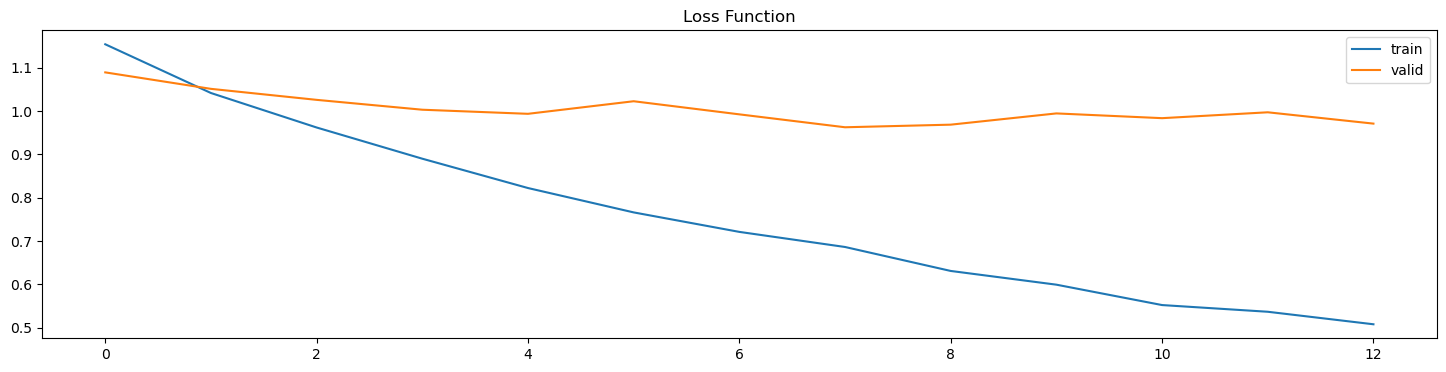

In [47]:
plt.figure(figsize=(18, 4))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

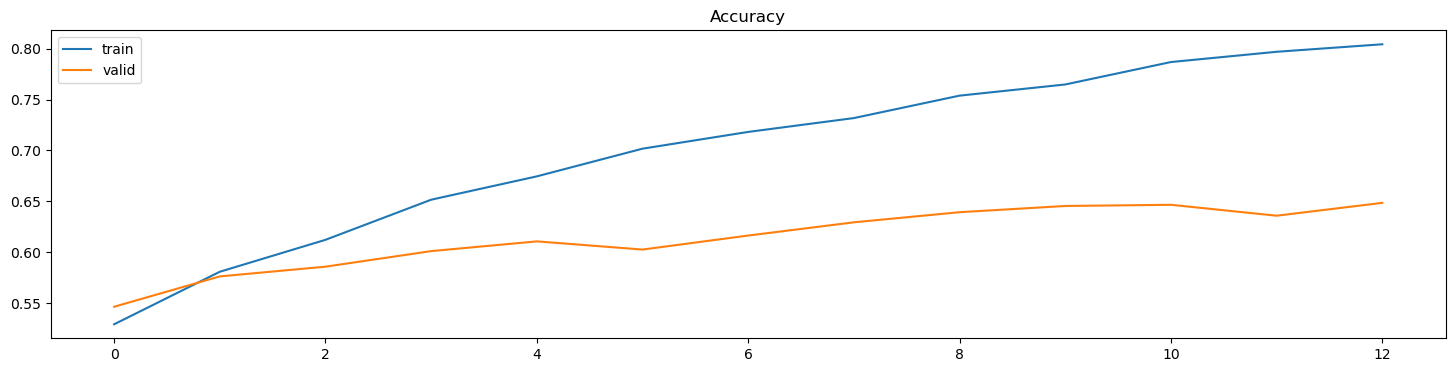

In [48]:
plt.figure(figsize=(18, 4))
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

### 1.7 Testing

In [49]:
test_loss, test_acc = model2.evaluate(validation_images, yvalidation, verbose=2)
print(test_acc)

82/82 - 214s - 3s/step - accuracy: 0.6478 - loss: 0.9945
0.6478227376937866


### 1.8 Some predictions

We have imported some interesting pictures to check if the model is working. The results are very convincing.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


'38-48'

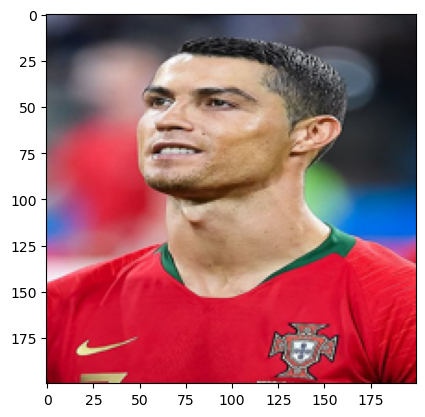

In [71]:
hola = Image.open('./cris.jpg')
hola = hola.resize((200, 200))   # Resize the image
plt.imshow(hola)
dato = np.asarray(hola)
# Display the image
dato2 = np.reshape(dato, (-1, 200, 200, 3))
predictions = model_cargado.predict(dato2)
age_to_label_map = {
    0:'0-2',
    1:'3-6',
    2:'8-23',
    3:'25-32',
    4:'38-48',
    5:'48-59',
    6:'60+'  
}
age_to_label_map[np.argmax(predictions)]

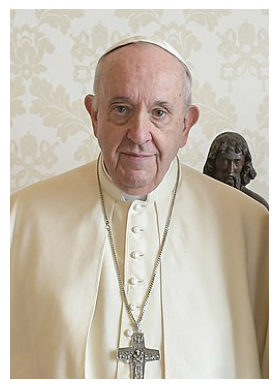

In [58]:
img = mpimg.imread('./Pope.jpg')
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

In [59]:
hola = Image.open('./Pope.jpg')
hola = hola.resize((200, 200))   # Resize the image
dato = np.asarray(hola)
# Display the image
dato2 = np.reshape(dato, (-1, 200, 200, 3))
predictions = model_cargado.predict(dato2)
age_to_label_map = {
    0:'0-2',
    1:'3-6',
    2:'8-23',
    3:'25-32',
    4:'38-48',
    5:'48-59',
    6:'60+'  
}
age_to_label_map[np.argmax(predictions)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


'60+'

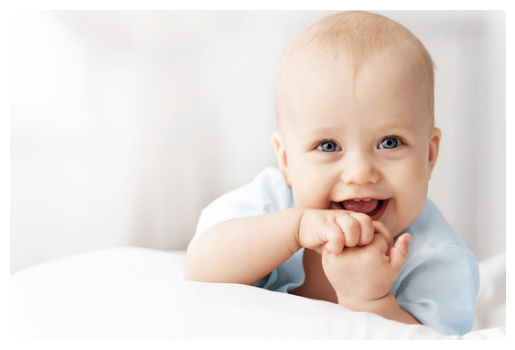

In [60]:
img = mpimg.imread('./bebe.jpg')
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

In [61]:
hola = Image.open('./bebe.jpg')
hola = hola.resize((200, 200))   # Resize the image
dato = np.asarray(hola)
# Display the image
dato2 = np.reshape(dato, (-1, 200, 200, 3))
predictions = model_cargado.predict(dato2)
age_to_label_map = {
    0:'0-2',
    1:'3-6',
    2:'8-23',
    3:'25-32',
    4:'38-48',
    5:'48-59',
    6:'60+'  
}
age_to_label_map[np.argmax(predictions)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


'0-2'

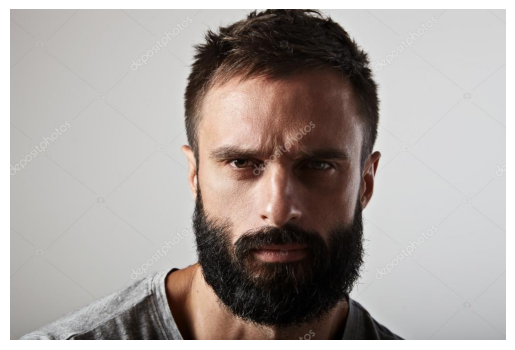

In [62]:
img = mpimg.imread('./barba.jpg')
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

In [63]:
hola = Image.open('./barba.jpg')
hola = hola.resize((200, 200))   # Resize the image
dato = np.asarray(hola)
# Display the image
dato2 = np.reshape(dato, (-1, 200, 200, 3))
predictions = model_cargado.predict(dato2)
age_to_label_map = {
    0:'0-2',
    1:'3-6',
    2:'8-23',
    3:'25-32',
    4:'38-48',
    5:'48-59',
    6:'60+'  
}
age_to_label_map[np.argmax(predictions)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


'25-32'